## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
import mnist
print(mnist.__file__)


/content/mnist.py


# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [33]:
# (re-)load layers
%run modules.ipynb

<>:3: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3092293347.py:3: SyntaxWarning: invalid escape sequence '\g'
  Implements linear transform of input y = \gamma * x + \beta


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

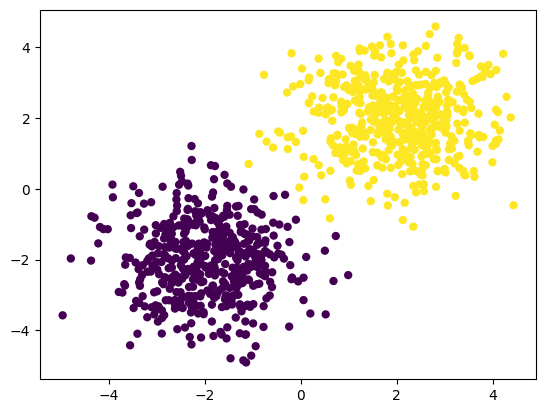

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

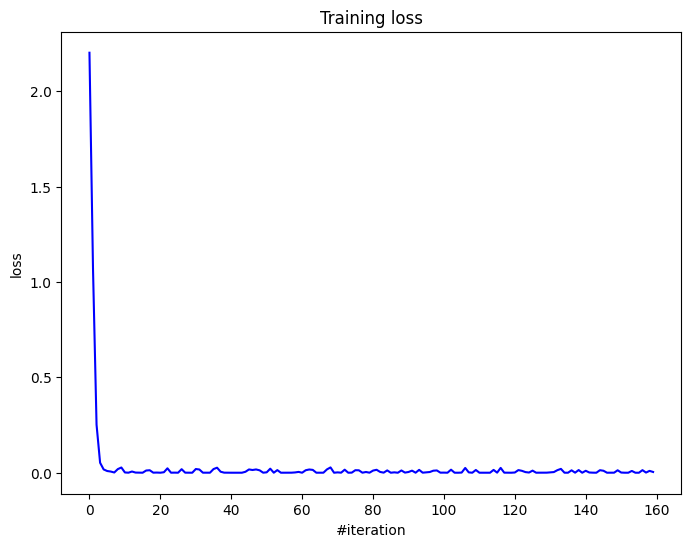

Current loss: 0.003961


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
#!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [ ]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

n_classes = 10
y_train_hot = np.eye(n_classes)[y_train]
y_test_hot = np.eye(n_classes)[y_test]
y_val_hot = np.eye(n_classes)[y_val]

print("Shape of y_train_hot:", y_train_hot.shape)

Shape of y_train_hot: (50000, 10)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

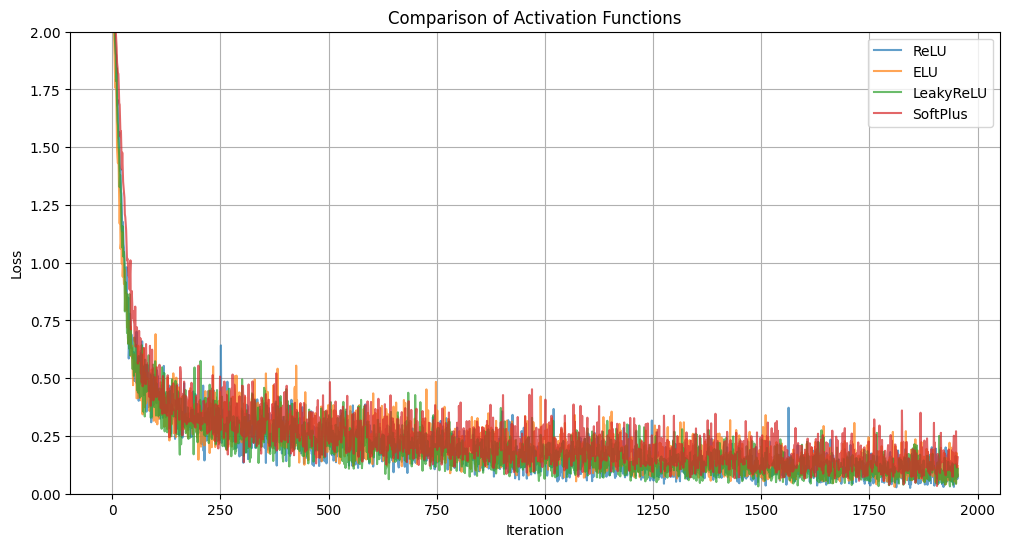

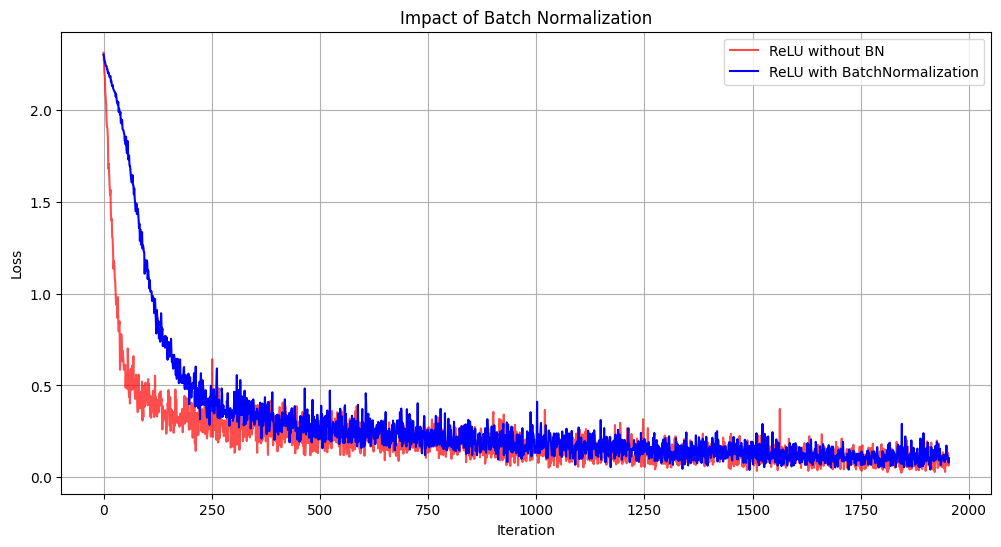

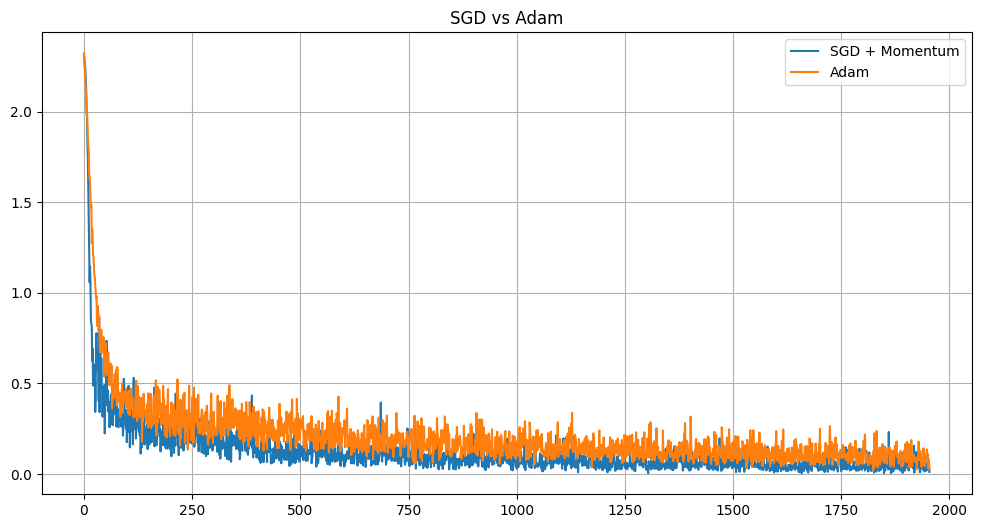

In [ ]:
# Your code goes here. ################################################

def train_network(net, optimizer_name='sgd_momentum', n_epoch=5, batch_size=128, learning_rate=0.1):

    if optimizer_name == 'sgd_momentum':
        optimizer_config = {'learning_rate': learning_rate, 'momentum': 0.9}
        optimizer = sgd_momentum
    elif optimizer_name == 'adam':
        optimizer_config = {'learning_rate': learning_rate, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
        optimizer = adam_optimizer

    optimizer_state = {}
    loss_history = []
    criterion = ClassNLLCriterion()

    net.train()

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train_hot), batch_size):
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer(net.getParameters(),
                      net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)

            loss_history.append(loss)

    return loss_history



#  Сравнение функций активации ---
activations = {
    'ReLU': ReLU(),
    'ELU': ELU(),
    'LeakyReLU': LeakyReLU(),
    'SoftPlus': SoftPlus()
}

loss_histories = {}

plt.figure(figsize=(12,6))

for name, act_layer in activations.items():
    # Flatten -> Linear -> Activation -> Linear -> LogSoftMax
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(784, 128))
    net.add(act_layer)
    net.add(Linear(128, 10))
    net.add(LogSoftMax())

    # Обучаем
    losses = train_network(net, optimizer_name='adam', n_epoch=5, learning_rate=1e-3)
    loss_histories[name] = losses

    # Сглаживание графика для красоты
    plt.plot(losses, label=name, alpha=0.7)

plt.title("Comparison of Activation Functions")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0, 2)
plt.grid()
plt.show()

# С BN и БЕЗ BN
plt.figure(figsize=(12, 6))
plt.plot(loss_histories['ReLU'], label='ReLU without BN', color='red', alpha=0.7)

net_bn = Sequential()
net_bn.add(Flatten())
net_bn.add(Linear(784, 128))
net_bn.add(BatchNormalization(alpha=0.9)) # BN слой
net_bn.add(ChannelwiseScaling(128))       # Scaling слой (gamma, beta)
net_bn.add(ReLU())
net_bn.add(Linear(128, 10))
net_bn.add(LogSoftMax())

losses_bn = train_network(net_bn, optimizer_name='adam', n_epoch=5, learning_rate=1e-3)
plt.plot(losses_bn, label='ReLU with BatchNormalization', color='blue')

plt.title("Impact of Batch Normalization")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

#  SGD vs Adam

plt.figure(figsize=(12, 6))

net_sgd = Sequential()
net_sgd.add(Flatten()); net_sgd.add(Linear(784, 128)); net_sgd.add(ReLU()); net_sgd.add(Linear(128, 10)); net_sgd.add(LogSoftMax())
losses_sgd = train_network(net_sgd, optimizer_name='sgd_momentum', learning_rate=0.1)

net_adam = Sequential()
net_adam.add(Flatten()); net_adam.add(Linear(784, 128)); net_adam.add(ReLU()); net_adam.add(Linear(128, 10)); net_adam.add(LogSoftMax())
losses_adam = train_network(net_adam, optimizer_name='adam', learning_rate=1e-3)

plt.plot(losses_sgd, label='SGD + Momentum')
plt.plot(losses_adam, label='Adam')
plt.title("SGD vs Adam")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def get_stats(history):
    # Берем последние 50 итераций, чтобы убрать шум
    history = np.array(history)
    final_loss = np.mean(history[-50:])

    # Оценка скорости сходимости
    threshold = 0.3
    below_thresh = np.where(history < threshold)[0]
    speed = below_thresh[0] if len(below_thresh) > 0 else "> Max Iter"

    return final_loss, speed

print(f"{'Experiment':<25} | {'Final Loss':<12} | {'Iter to Loss<0.3':<15}")
print("-" * 60)

#  Активации
for name, hist in loss_histories.items():
    loss, speed = get_stats(hist)
    print(f"{name:<25} | {loss:.4f}       | {speed:<15}")

print("-" * 60)

#  Batch Normalization
loss_no_bn, speed_no_bn = get_stats(loss_histories['ReLU'])
loss_bn, speed_bn = get_stats(losses_bn)
print(f"{'ReLU (No BN)':<25} | {loss_no_bn:.4f}       | {speed_no_bn:<15}")
print(f"{'ReLU + Batch Norm':<25} | {loss_bn:.4f}       | {speed_bn:<15}")

print("-" * 60)

#  Оптимизаторы
loss_sgd, speed_sgd = get_stats(losses_sgd)
loss_adam, speed_adam = get_stats(losses_adam)
print(f"{'SGD + Momentum':<25} | {loss_sgd:.4f}       | {speed_sgd:<15}")
print(f"{'Adam':<25} | {loss_adam:.4f}       | {speed_adam:<15}")

Experiment                | Final Loss   | Iter to Loss<0.3
------------------------------------------------------------
ReLU                      | 0.0996       | 136            
ELU                       | 0.1097       | 120            
LeakyReLU                 | 0.0904       | 114            
SoftPlus                  | 0.1457       | 132            
------------------------------------------------------------
ReLU (No BN)              | 0.0996       | 136            
ReLU + Batch Norm         | 0.1123       | 245            
------------------------------------------------------------
SGD + Momentum            | 0.0578       | 48             
Adam                      | 0.0848       | 123            


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?



**1. Activation Functions Comparison:**
В данном эксперименте победителем стала **LeakyReLU**.
- **LeakyReLU** показала лучший (наименьший) Final Loss = **0.0904** и самую быструю сходимость (114 итераций). Это объясняется тем, что она решает проблему "мертвых нейронов" (vanishing gradient для $x < 0$), пропуская небольшой сигнал даже для отрицательных значений.
- **ReLU** заняла второе место (Loss = 0.0996). Стандартный и надежный выбор.
- **SoftPlus** показал худший результат (Loss = 0.1457). Функция слишком гладкая, и вычисление экспонент/логарифмов замедляет процесс и усложняет оптимизацию по сравнению с простыми кусочно-линейными функциями.

**2. Batch Normalization Impact:**
В текущем сетапе Batch Normalization **не помог**, а даже ухудшил результаты.
- Без BN сеть сошлась за **136** итераций.
- С BN сеть сходилась гораздо дольше — **245** итераций.
- Финальный Loss с BN выше (хуже): 0.1123 против 0.0996.


 **Помогает ли BatchNormalization?**

В **данном конкретном эксперименте — нет**. Он замедлил сходимость и ухудшил лосс.
    *   **Почему?**
        1.  **Шум на старте:** На маленьких батчах или в начале обучения статистики (mean/std) сильно скачут, что мешает оптимизатору.
        2.  **Накладные расходы:** Вычисление среднего и дисперсии — это дополнительные операции на каждом шаге.
        3.  **Архитектура:** Для простой полносвязной сети на MNIST проблема затухания сигнала не стоит остро, поэтому "лекарство" (BN) оказалось тяжелее "болезни". Однако в глубоких сверточных сетях (ResNet и т.д.) BN является обязательным компонентом.


**3. Optimizers (SGD vs Adam):**
**SGD + Momentum** оказался значительно эффективнее.
- Скорость сходимости SGD (48 итераций) почти в **2.5 раза выше**, чем у Adam (123 итерации).
- Финальный Loss у SGD (0.0578) значительно лучше, чем у Adam (0.0848).
Это классический пример того, как на простых ландшафтах потерь "грубая сила" SGD с высоким Learning Rate (0.1) работает лучше, чем осторожные адаптивные шаги Adam с низким Learning Rate (0.001).

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################

model = Sequential()
model.add(Flatten())

# Слой 1: 784 -> 512
model.add(Linear(784, 512))
model.add(BatchNormalization(alpha=0.9))
model.add(ChannelwiseScaling(512))
model.add(ReLU())
model.add(Dropout(p=0.3)) # для регуляризации

# Слой 2: 512 -> 256
model.add(Linear(512, 256))
model.add(BatchNormalization(alpha=0.9))
model.add(ChannelwiseScaling(256))
model.add(ReLU())
model.add(Dropout(p=0.3))

# Выходной слой: 256 -> 10
model.add(Linear(256, 10))
model.add(LogSoftMax())

print("Training best model...")

optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
optimizer_state = {}
criterion = ClassNLLCriterion()

n_epochs = 10
batch_size = 128
loss_history = []

model.train()

for i in range(n_epochs):
    if i > 5:
        optimizer_config['learning_rate'] *= 0.5

    epoch_loss = 0
    start_time = time()

    for x_batch, y_batch in get_batches((X_train, y_train_hot), batch_size):
        model.zeroGradParameters()

        # Forward и Backward
        pred = model.forward(x_batch)
        loss = criterion.forward(pred, y_batch)
        dp = criterion.backward(pred, y_batch)
        model.backward(x_batch, dp)

        # step
        adam_optimizer(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
        epoch_loss += loss

    print(f"Epoch {i+1}/{n_epochs} | Time: {time() - start_time:.2f}s | Mean Loss: {epoch_loss / (X_train.shape[0]/batch_size):.4f}")

Training best model...
Epoch 1/10 | Time: 19.68s | Mean Loss: 0.5883
Epoch 2/10 | Time: 17.58s | Mean Loss: 0.1190
Epoch 3/10 | Time: 17.41s | Mean Loss: 0.0861
Epoch 4/10 | Time: 17.32s | Mean Loss: 0.0670
Epoch 5/10 | Time: 19.80s | Mean Loss: 0.0589
Epoch 6/10 | Time: 17.44s | Mean Loss: 0.0495
Epoch 7/10 | Time: 17.42s | Mean Loss: 0.0327
Epoch 8/10 | Time: 18.94s | Mean Loss: 0.0227
Epoch 9/10 | Time: 18.14s | Mean Loss: 0.0195
Epoch 10/10 | Time: 19.74s | Mean Loss: 0.0183


Print here your accuracy on test set. It should be around 90%.


**Accuracy: 98.42%**

In [ ]:
# Your answer goes here. ################################################

model.evaluate()

correct = 0
total = 0

for x_batch, y_batch in get_batches((X_test, y_test_hot), batch_size):
    # Forward
    pred = model.forward(x_batch)
    # классы
    pred_classes = np.argmax(pred, axis=1)
    true_classes = np.argmax(y_batch, axis=1)

    correct += np.sum(pred_classes == true_classes)
    total += x_batch.shape[0]

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")



Accuracy: 98.42%


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(np.argmax(y_train_hot, axis=1)))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(np.argmax(y_test_hot, axis=1)))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# Аналогичная модель
model_pt = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1)
).to(device)

opt = optim.Adam(model_pt.parameters(), lr=1e-3)
crit = nn.NLLLoss()

# Обучение

model_pt.train()
for epoch in range(5):
    for x_b, y_b in train_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        opt.zero_grad()
        out = model_pt(x_b)
        loss = crit(out, y_b)
        loss.backward()
        opt.step()

# Тест
model_pt.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_b, y_b in test_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        out = model_pt(x_b)
        _, preds = torch.max(out, 1)
        correct += (preds == y_b).sum().item()
        total += y_b.size(0)

print(f"PyTorch Accuracy: {correct/total*100:.2f}%")

PyTorch Accuracy: 98.17%
